### OpenCV : Core Tools for VisionExtract

- What is OpenCV?
  OpenCV (Open Source Computer Vision Library) is a powerful, open-source library for real-time image and video processing. In VisionExtract, it's essential for loading, preprocessing, and manipulating images before they reach the deep learning model.

- Key Capabilities:

  - Image I/O (read/write various formats)

  - Image transformations (resize, crop, rotate)

  - Color space conversions (RGB ↔ grayscale ↔ HSV)

  - Filtering and edge detection

  - Morphological operations (erosion, dilation)

  - Fast C++ backend with Python bindings

- Installation:

In [5]:
!pip install opencv-python


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 1. Loading and Displaying Images
- `OpenCV` loads images as NumPy arrays where pixel values range from 0-255. It uses BGR format (not RGB) by default.

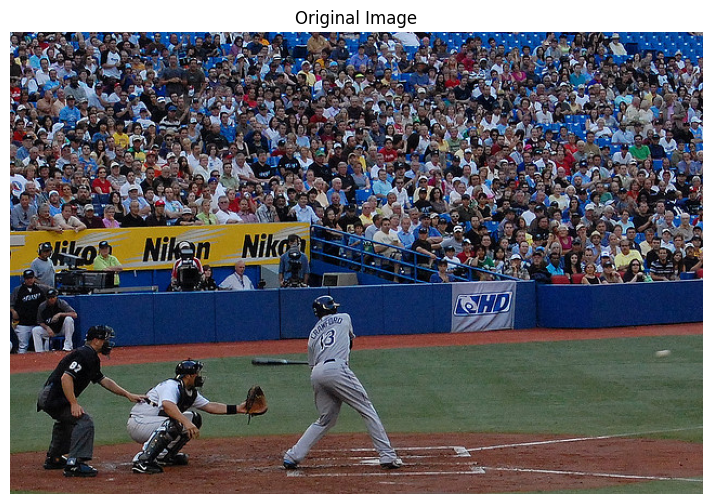

Image shape: (427, 640, 3)
Data type: uint8
Value range: 0-255


In [6]:
import cv2
import matplotlib.pyplot as plt

# Load image in BGR format (default)
image_bgr = cv2.imread(r'C:\Users\Ravichandran\datasets\vision_extract\coco2017\train2017\000000000544.jpg')

# Important: Convert BGR to RGB for proper visualization
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display image
plt.figure(figsize=(10,6))
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Check image shape and data type
print(f"Image shape: {image_rgb.shape}")  # (height, width, channels)
print(f"Data type: {image_rgb.dtype}")    # uint8
print(f"Value range: {image_rgb.min()}-{image_rgb.max()}")  # 0-255

- Key Points:

    - Always convert BGR → RGB when working with matplotlib or sending to models

    - Image shape is (height, width, channels), not (width, height, channels)

    - Pixel values are typically uint8 (0-255), but models expect normalized float32 (0-1)

#### 2. Image Resizing - Critical for Model Input
- Deep learning models require fixed input sizes. COCO-2017 images have varying resolutions, so resizing standardizes them to 512×512.

In [7]:
import numpy as np

# Method-1: Simple Resize
image_resized = cv2.resize(image_rgb, (512, 512))
print(f" Real Image shape: {image_rgb.shape}")
print(f" Resized shape: {image_resized.shape}")

# Method 2: Resize with aspect ratio preservation (padding)
height, width = image_rgb.shape[:2]
scale = 512 / max(height, width)
new_width = int(width * scale)
new_height = int(height * scale)

# Resize
image_resized = cv2.resize(image_rgb, (new_width, new_height))

# Create canvas and pad with black
canvas = np.zeros((512, 512, 3), dtype=np.uint8)
y_offset = (512 - new_height) // 2
x_offset = (512 - new_width) // 2
canvas[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = image_resized

print(f" Padded shape: {canvas.shape}")  # (512, 512, 3)

 Real Image shape: (427, 640, 3)
 Resized shape: (512, 512, 3)
 Padded shape: (512, 512, 3)


- Why This Matters:

    - Simple resize: Fast but distorts aspect ratio (avoid if possible)

    - Padding: Preserves aspect ratio but adds black borders (better for object detection)

    - For VisionExtract, simple 512×512 resize works fine since we have masks

#### 3. Color Space Conversion
- Some models work better with grayscale, HSV helps with lighting invariance, etc.

Grayscale shape: (427, 640)


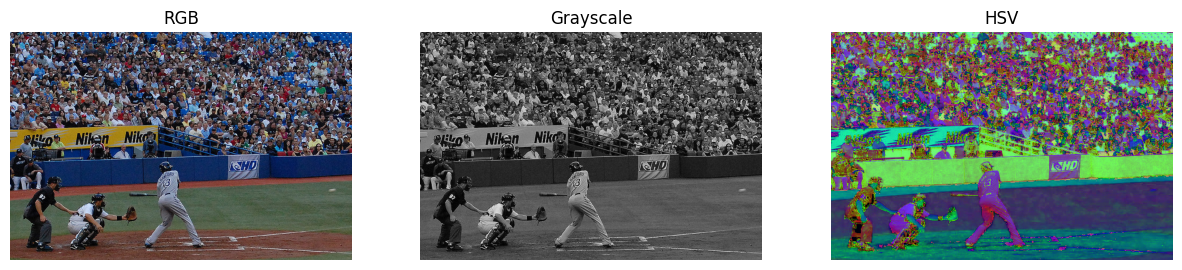

In [8]:
# RGB to Grayscale
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
print(f"Grayscale shape: {image_gray.shape}")  # (height, width) - NO channel dimension

# RGB to HSV (useful for color-based segmentation)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
   
# Visualize all three
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_rgb)
axes[0].set_title("RGB")
axes[0].axis('off')

axes[1].imshow(image_gray, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis('off')

axes[2].imshow(image_hsv)
axes[2].set_title("HSV")
axes[2].axis('off')

plt.show()

#### 4. Image Normalization - Prepare for Models
- Critical Step: Models expect pixel values in range [-1, 1].

In [9]:
# Method 1: Simple normalization (0-1)
image_normalized = image_rgb.astype(np.float32) / 255.0
print(f"Value range: {image_normalized.min()}-{image_normalized.max()}")  # 0.0-1.0

# Method 2: ImageNet normalization (standard for pre-trained models)
# Pre-trained models (ResNet, VGG, etc.) expect this normalization
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean (RGB)
std = np.array([0.229, 0.224, 0.225])   # ImageNet std (RGB)

image_normalized = (image_normalized - mean) / std
print(f"Value range: {image_normalized.min():.3f}-{image_normalized.max():.3f}")

Value range: 0.0-1.0
Value range: -2.118-2.640


- Why ImageNet normalization?
    - Pre-trained encoders (ResNet50, etc.) were trained on ImageNet with this normalization
    - Using it ensures the model receives inputs in the same scale as training

- Passing non-normalized vs normalized image to model
    - ❌ Without normalization: Model sees pixel values 0-255 (extreme range)
    - ✓ With normalization: Model sees values -2.0 to 2.0 (expected range)
    - This improves gradient flow and training stability!

#### 5. Reading and Processing Masks
- For VisionExtract: Masks are grayscale images where pixel values represent class labels.

Mask shape: (427, 640)
Unique values in mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 

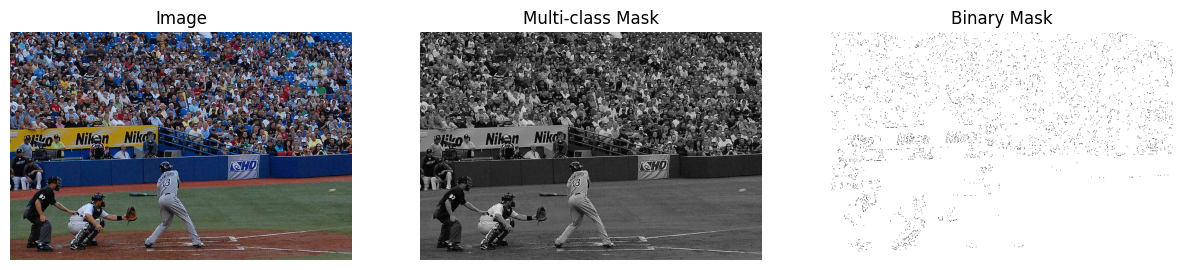

In [10]:
# Load mask in grayscale (single channel)
mask = cv2.imread(r'C:\Users\Ravichandran\datasets\vision_extract\coco2017\train2017\000000000544.jpg', cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError("mask.jpg not found or cannot be loaded.")
print(f"Mask shape: {mask.shape}")  # (height, width)
print(f"Unique values in mask: {np.unique(mask)}")  # Check all pixel values

# Convert multi-class mask to binary (subject=1, background=0)
binary_mask = (mask > 0).astype(np.uint8)  # 0 and 1
print(f"Binary mask unique values: {np.unique(binary_mask)}")  # [0, 1]

# Visualize the images and masks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_rgb)
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Multi-class Mask")
axes[1].axis('off')

axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title("Binary Mask")
axes[2].axis('off')

plt.show()

#### 6. Morphological Operations - Post-processing
- After model prediction, morphological operations clean up noisy masks.

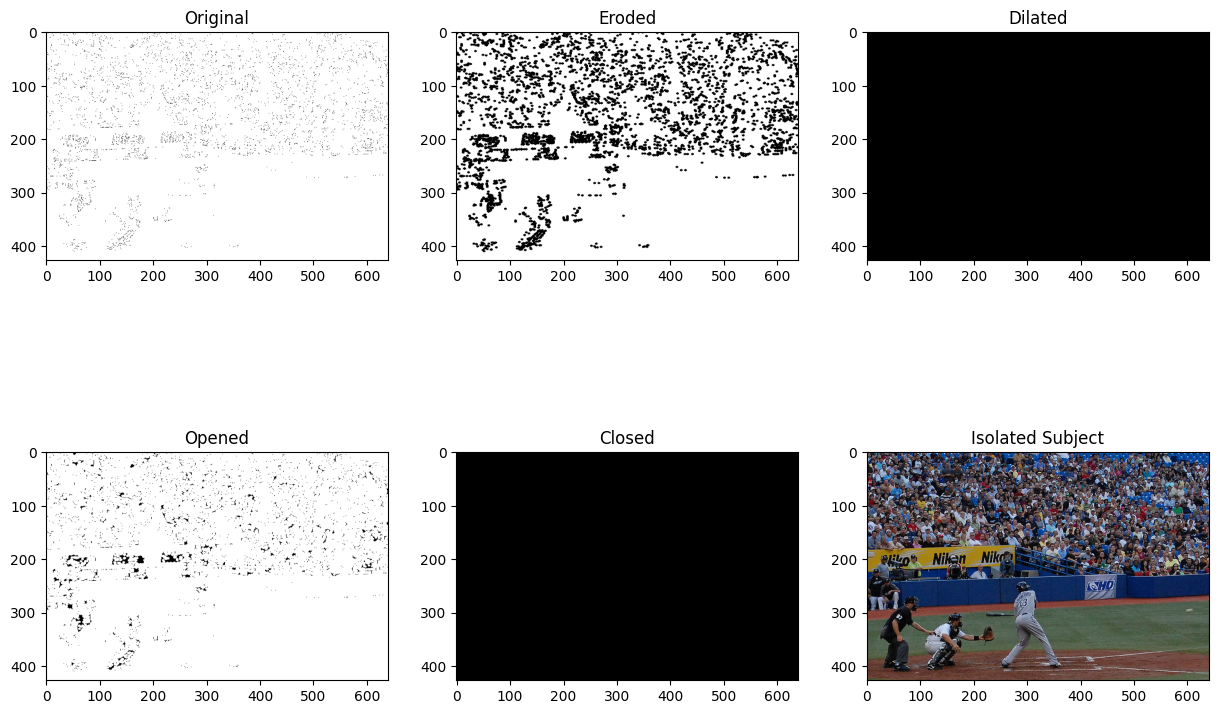

In [11]:
# Erosion: Removes small white noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode(binary_mask, kernel, iterations=1)

# Dilation: Fills small holes
mask_dilated = cv2.dilate(binary_mask, kernel, iterations=1)

# Closing: Dilation followed by erosion (fills holes)
mask_closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Opening: Erosion followed by dilation (removes noise)
mask_opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Visualize effects
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(binary_mask, cmap='gray')
axes[0, 0].set_title("Original")

axes[0, 1].imshow(mask_eroded, cmap='gray')
axes[0, 1].set_title("Eroded")

axes[0, 2].imshow(mask_dilated, cmap='gray')
axes[0, 2].set_title("Dilated")

axes[1, 0].imshow(mask_opened, cmap='gray')
axes[1, 0].set_title("Opened")

axes[1, 1].imshow(mask_closed, cmap='gray')
axes[1, 1].set_title("Closed")

# Apply mask to image (isolate subject)
isolated = np.zeros_like(image_rgb)
isolated[mask_closed > 0] = image_rgb[mask_closed > 0]
axes[1, 2].imshow(isolated)
axes[1, 2].set_title("Isolated Subject")

plt.show()

- Key Teaching Points:

    - Erosion: Shrinks white regions, removes thin features

    - Dilation: Expands white regions, fills holes

    - Closing: Good for removing small noise

    - Opening: Good for removing thin artifacts

#### 7. Image Filtering - Blur and Edge Detection

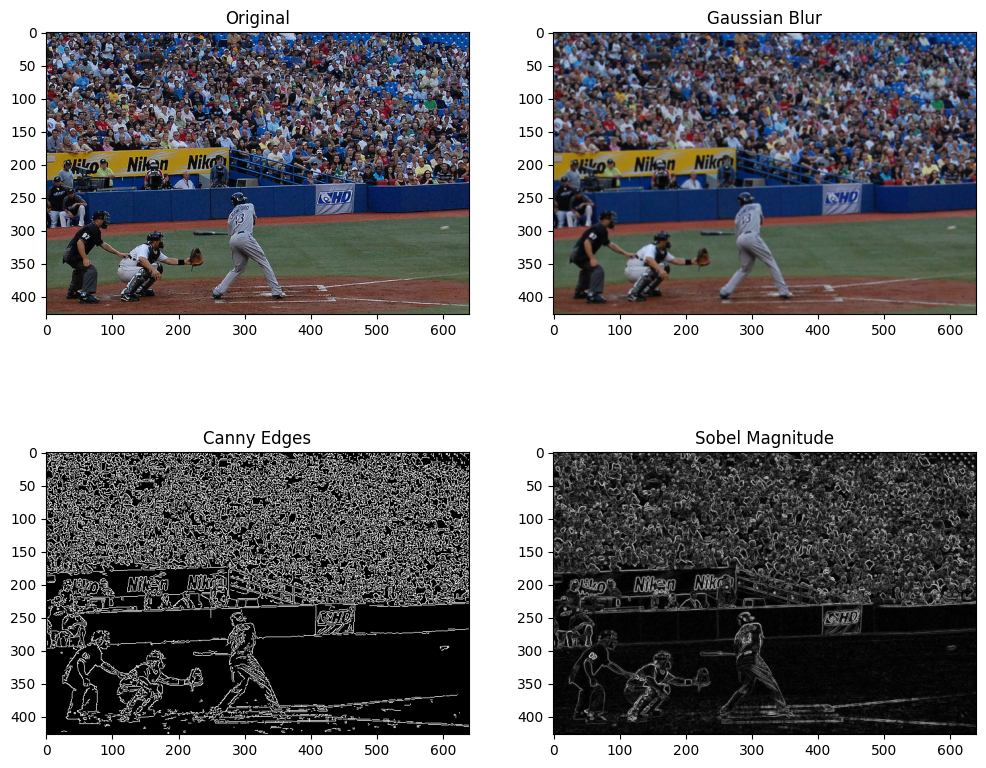

In [12]:
# Gaussian Blur: Smooth image (reduce noise)
blurred = cv2.GaussianBlur(image_rgb, (5, 5), 1.0)

# Canny Edge Detection
edges = cv2.Canny(image_gray, 100, 200)

# Sobel operators (gradient-based edge detection)
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title("Original")

axes[0, 1].imshow(blurred)
axes[0, 1].set_title("Gaussian Blur")

axes[1, 0].imshow(edges, cmap='gray')
axes[1, 0].set_title("Canny Edges")

axes[1, 1].imshow(sobel_magnitude, cmap='gray')
axes[1, 1].set_title("Sobel Magnitude")

plt.show()